In [1]:
# load the weighted_avg from data/
import pickle

with open('data/weighted_avg_sat.pkl', 'rb') as f:
    weighted_avg_sat = pickle.load(f)

with open('data/weighted_avg_sic.pkl', 'rb') as f:
    weighted_avg_sic = pickle.load(f)

with open('data/weighted_avg_pre.pkl', 'rb') as f:
    weighted_avg_pre = pickle.load(f)

# Rename the keys and merge

In [7]:
renamed_weighted_avg_sat = {f'sat {k}': v for k, v in weighted_avg_sat.items()}
renamed_weighted_avg_sic = {f'sic {k}': v for k, v in weighted_avg_sic.items()}
renamed_weighted_avg_pre = {f'pre {k}': v for k, v in weighted_avg_pre.items()}

# Initialize an empty dictionary
merged_dict = {}

# Merge the three dictionaries into one
merged_dict.update(renamed_weighted_avg_sat)
merged_dict.update(renamed_weighted_avg_sic)
merged_dict.update(renamed_weighted_avg_pre)


In [19]:
import numpy as np

normalized_dict = {}

for key, array in merged_dict.items():
    mean = np.mean(array)
    std = np.std(array)
    normalized_array = (array - mean) / std
    normalized_dict[key] = normalized_array


merged_dict=normalized_dict

# PCMCI (using normalized data)

(<Figure size 640x480 with 11 Axes>,
 array([<Axes: ylabel='pre 0'>, <Axes: ylabel='pre 1'>,
        <Axes: ylabel='pre 2'>, <Axes: ylabel='sat 0'>,
        <Axes: ylabel='sat 1'>, <Axes: ylabel='sat 2'>,
        <Axes: ylabel='sat 3'>, <Axes: ylabel='sic 0'>,
        <Axes: ylabel='sic 1'>, <Axes: ylabel='sic 2'>,
        <Axes: ylabel='sic 3'>], dtype=object))

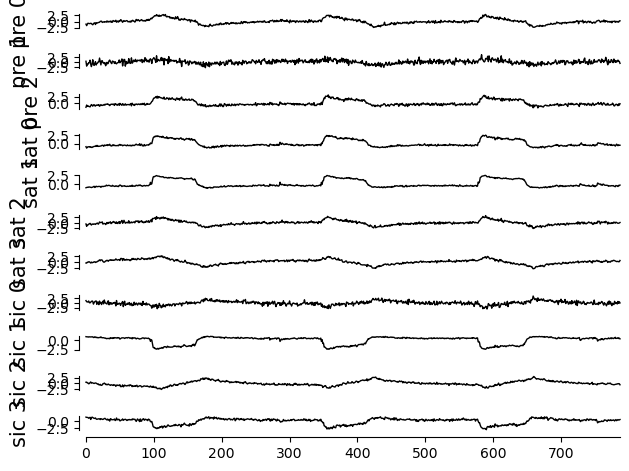

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = np.column_stack([merged_dict[key] for key in sorted(merged_dict.keys())])

# Create a Tigramite DataFrame object
var_names = [f"{k}" for k in sorted(merged_dict.keys())]
dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)

In [24]:
var_names

['pre 0',
 'pre 1',
 'pre 2',
 'sat 0',
 'sat 1',
 'sat 2',
 'sat 3',
 'sic 0',
 'sic 1',
 'sic 2',
 'sic 3']


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable pre 0 has 11 link(s):
    [pc_alpha = 0.4]
        (sic 0 -1): max_pval = 0.00004, |min_val| =  0.146
        (pre 2 -1): max_pval = 0.00146, |min_val| =  0.114
        (sat 2 -1): max_pval = 0.02021, |min_val| =  0.083
        (sic 2 -1): max_pval = 0.14122, |min_val| =  0.053
        (sat 0 -1): max_pval = 0.28081, |min_val| =  0.039
        (sic 1 -1): max_pval = 0.29362, |min_val| =  0.038
        (pre 0 -2): max_pval = 0.30218, |min_val| =  0.037
        (sic 2 -2): max_pval = 0.31403, |min_val| =  0.036
        (sat 2 -2): max_pval = 0.31810, |min_val| =  0.036
        (pre 1 -1): max_pval = 0.34215, |min_val| =  0.034
        (sat 1 -1): max_pval = 0.39024, |min_val| =  0.031

    Variable pre 1 has 4 link(s):
 

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

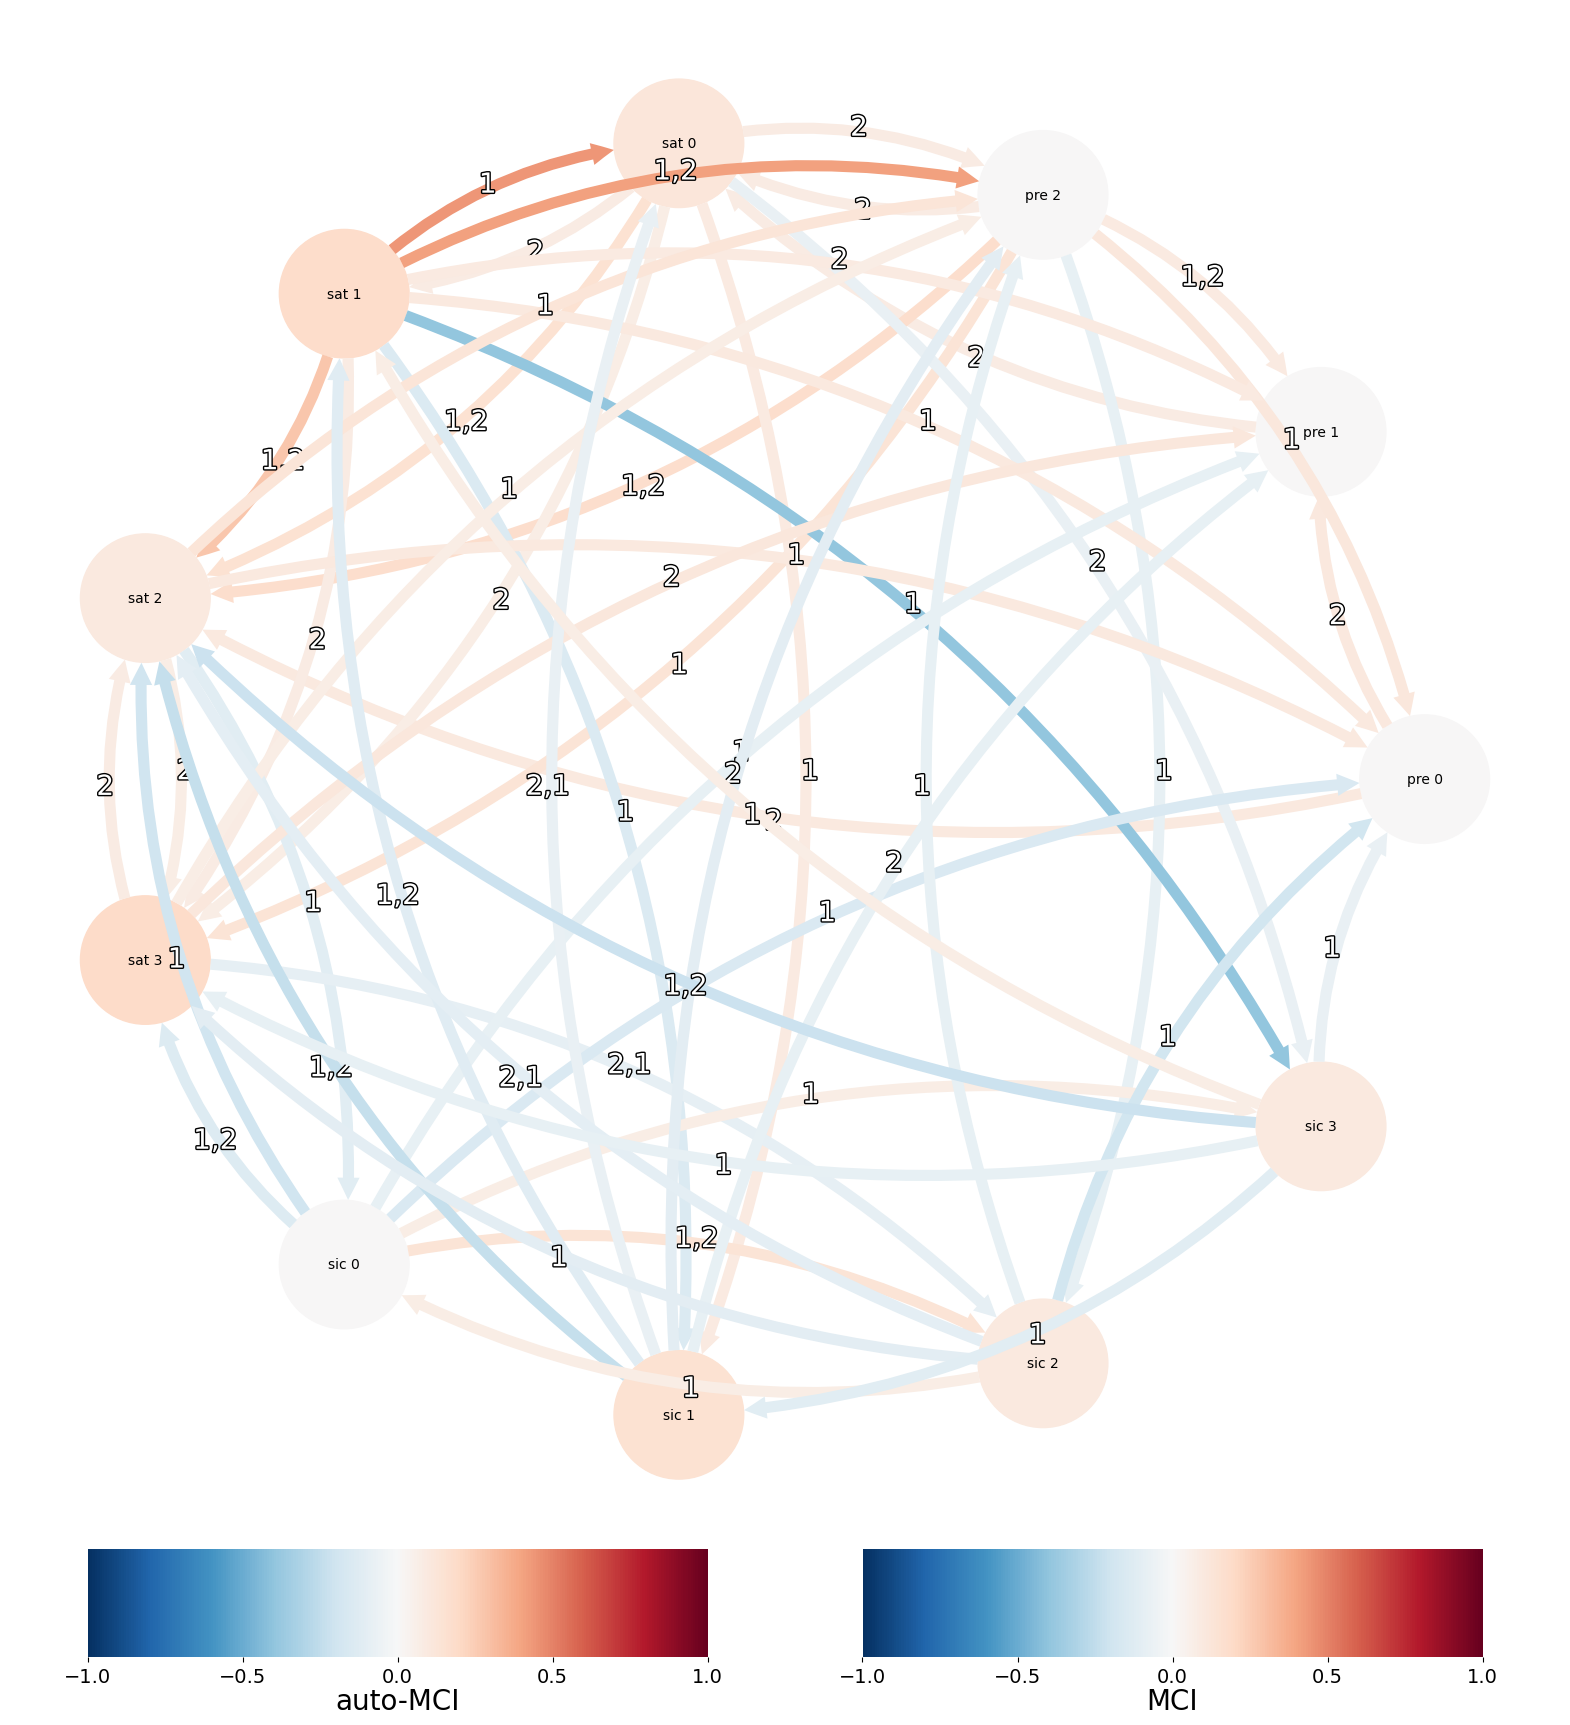

In [21]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )



In [26]:
results['p_matrix'].shape

(11, 11, 3)

In [173]:
import numpy as np

def print_significant_links(N, var_names, p_matrix, val_matrix, alpha_level=0.05):
    """Generates and returns significant links based on p-values and values matrices.

    Parameters
    ----------
    N : int
        The number of variables (typically, this is the shape of the first dimension of p_matrix and val_matrix).
    var_names : list of str
        Names of the variables corresponding to the dimensions of p_matrix and val_matrix.
    alpha_level : float, optional (default: 0.05)
        Significance level.
    p_matrix : array-like
        P-values matrix of shape (N, N, tau_max + 1).
    val_matrix : array-like
        Values matrix of shape (N, N, tau_max + 1).
    
    Returns
    -------
    str
        A string containing formatted significant links information.
    """
    sig_links = p_matrix <= alpha_level
    results_text = "\n## Significant links at alpha = %s:\n" % alpha_level

    for j in range(N):
        links = {(p[0], -p[1]): np.abs(val_matrix[p[0], j, abs(p[1])])
                 for p in zip(*np.where(sig_links[:, j, :]))}
        # Sort by value
        sorted_links = sorted(links, key=links.get, reverse=True)
        n_links = len(links)
        string = "    Variable %s has %d link(s):" % (var_names[j], n_links)
        for p in sorted_links:
            string += "\n        (%s % d): pval = %.5f" % (
                var_names[p[0]], p[1], p_matrix[p[0], j, abs(p[1])])
            string += " | val = % .3f" % (val_matrix[p[0], j, abs(p[1])])
        results_text += string + "\n"
        print(string)

    return results_text




import re

def parse_results_to_dict(results_text, var_names):
    causal_links = {}
    lines = results_text.split('\n')
    
    current_var = None
    for line in lines:
        print(repr(line))  # Use repr to show hidden characters like tabs or multiple spaces

        if "Variable" in line:
            match = re.search(r"Variable\s+(.*?)\s+has", line)  # More flexible with spaces
            if match:
                current_var_name = match.group(1)
                current_var = var_names.index(current_var_name)
                print("target var:", current_var_name)
                causal_links[current_var_name] = []

        elif "pval =" in line:
            cause_match = re.search(r"\((.*?)\)", line)
            print("Cause match found:", cause_match)
            pval_match = re.search(r"pval = ([\d\.]+)", line)
            # More robust regex, considering possible extra spaces and different formatting
            val_match = re.search(r"\|\s*val\s*=\s*([-\d\.]+)", line)

            print("Val match found:", val_match)

            lag_match = re.search(r"(\-\d+)", cause_match.group(1))
            
            if cause_match and pval_match and val_match and lag_match:
                cause_name = cause_match.group(1).split(' ')[0]+' '+ cause_match.group(1).split(' ')[1]  # Ensure correct format
                print(cause_match.group(1).split(' '))
                print("Cause name:", cause_name)
                cause_index = var_names.index(cause_name)
                print("Cause index:", cause_index)
                link_detail = {
                    "cause": cause_name,
                    "lag": int(lag_match.group(1)),
                    "pval": float(pval_match.group(1)),
                    "val": float(val_match.group(1))
                }
                causal_links[current_var_name].append(link_detail)
    
    return causal_links



def sort_causal_links_by_val(causal_links, ascending=True):
    sorted_causal_links = {}
    for key, links in causal_links.items():
        sorted_links = sorted(links, key=lambda x: abs(x['val']), reverse=not ascending)
        sorted_causal_links[key] = sorted_links
    return sorted_causal_links





N = results['p_matrix'].shape[0]
var_names = var_names


results_text=print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)

causal_links = parse_results_to_dict(results_text, var_names)
causal_links

causal_links = sort_causal_links_by_val(causal_links)
causal_links

    Variable pre 0 has 6 link(s):
        (sic 2 -1): pval = 0.00000 | val = -0.189
        (sic 0 -1): pval = 0.00003 | val = -0.150
        (pre 2 -1): pval = 0.00133 | val =  0.115
        (sat 1 -1): pval = 0.00513 | val =  0.101
        (sat 2 -1): pval = 0.00678 | val =  0.098
        (sic 3 -1): pval = 0.03835 | val = -0.075
    Variable pre 1 has 7 link(s):
        (sat 3 -2): pval = 0.00134 | val =  0.115
        (pre 0 -2): pval = 0.00412 | val =  0.103
        (pre 2 -1): pval = 0.00933 | val =  0.093
        (sat 1 -2): pval = 0.01017 | val =  0.093
        (pre 2 -2): pval = 0.01162 | val =  0.090
        (sic 1 -2): pval = 0.02188 | val = -0.082
        (sic 0 -1): pval = 0.02967 | val = -0.078
    Variable pre 2 has 7 link(s):
        (sat 1 -1): pval = 0.00000 | val =  0.407
        (sat 2 -1): pval = 0.00036 | val =  0.128
        (sic 1 -2): pval = 0.00429 | val = -0.102
        (sat 0 -2): pval = 0.01872 | val =  0.085
        (sic 2 -1): pval = 0.01873 | val = -0.08

{'pre 0': [{'cause': 'sic 3', 'lag': -1, 'pval': 0.03835, 'val': -0.075},
  {'cause': 'sat 2', 'lag': -1, 'pval': 0.00678, 'val': 0.098},
  {'cause': 'sat 1', 'lag': -1, 'pval': 0.00513, 'val': 0.101},
  {'cause': 'pre 2', 'lag': -1, 'pval': 0.00133, 'val': 0.115},
  {'cause': 'sic 0', 'lag': -1, 'pval': 3e-05, 'val': -0.15},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.0, 'val': -0.189}],
 'pre 1': [{'cause': 'sic 0', 'lag': -1, 'pval': 0.02967, 'val': -0.078},
  {'cause': 'sic 1', 'lag': -2, 'pval': 0.02188, 'val': -0.082},
  {'cause': 'pre 2', 'lag': -2, 'pval': 0.01162, 'val': 0.09},
  {'cause': 'pre 2', 'lag': -1, 'pval': 0.00933, 'val': 0.093},
  {'cause': 'sat 1', 'lag': -2, 'pval': 0.01017, 'val': 0.093},
  {'cause': 'pre 0', 'lag': -2, 'pval': 0.00412, 'val': 0.103},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00134, 'val': 0.115}],
 'pre 2': [{'cause': 'sat 3', 'lag': -1, 'pval': 0.03264, 'val': 0.077},
  {'cause': 'sat 1', 'lag': -2, 'pval': 0.02963, 'val': 0.078},
  {'cause': 's

# Clean the causal_links and remove the causal link from the same variable

In [174]:
def clean_causal_links(causal_links):
    cleaned_links = {}
    for target, links in causal_links.items():
        target_prefix = target.split(' ')[0]  
        # print("target prefix:", target_prefix)
        # Filter links where the cause prefix matches the target prefix
        filtered_links = [link for link in links if not link['cause'].startswith(target_prefix)]
        cleaned_links[target] = filtered_links
    return cleaned_links


causal_links = clean_causal_links(causal_links)
causal_links

# remove items with abs(val) < 0.1
def filter_causal_links_by_val(causal_links, threshold=0.1):
    filtered_links = {}
    for target, links in causal_links.items():
        filtered_links[target] = [link for link in links if abs(link['val']) >= threshold]
    return filtered_links


causal_links = filter_causal_links_by_val(causal_links, threshold=0.12)
causal_links

{'pre 0': [{'cause': 'sic 0', 'lag': -1, 'pval': 3e-05, 'val': -0.15},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.0, 'val': -0.189}],
 'pre 1': [],
 'pre 2': [{'cause': 'sat 2', 'lag': -1, 'pval': 0.00036, 'val': 0.128},
  {'cause': 'sat 1', 'lag': -1, 'pval': 0.0, 'val': 0.407}],
 'sat 0': [],
 'sat 1': [{'cause': 'sic 1', 'lag': -1, 'pval': 0.00085, 'val': -0.12}],
 'sat 2': [{'cause': 'pre 2', 'lag': -2, 'pval': 0.0, 'val': 0.174},
  {'cause': 'pre 2', 'lag': -1, 'pval': 0.0, 'val': 0.175},
  {'cause': 'sic 0', 'lag': -1, 'pval': 0.0, 'val': -0.203},
  {'cause': 'sic 3', 'lag': -1, 'pval': 0.0, 'val': -0.215},
  {'cause': 'sic 1', 'lag': -2, 'pval': 0.0, 'val': -0.226},
  {'cause': 'sic 1', 'lag': -1, 'pval': 0.0, 'val': -0.236}],
 'sat 3': [{'cause': 'sic 0', 'lag': -1, 'pval': 0.00012, 'val': -0.138},
  {'cause': 'pre 2', 'lag': -1, 'pval': 0.00011, 'val': 0.139}],
 'sic 0': [],
 'sic 1': [{'cause': 'sat 1', 'lag': -1, 'pval': 6e-05, 'val': -0.144}],
 'sic 2': [],
 'sic 3': [{'caus

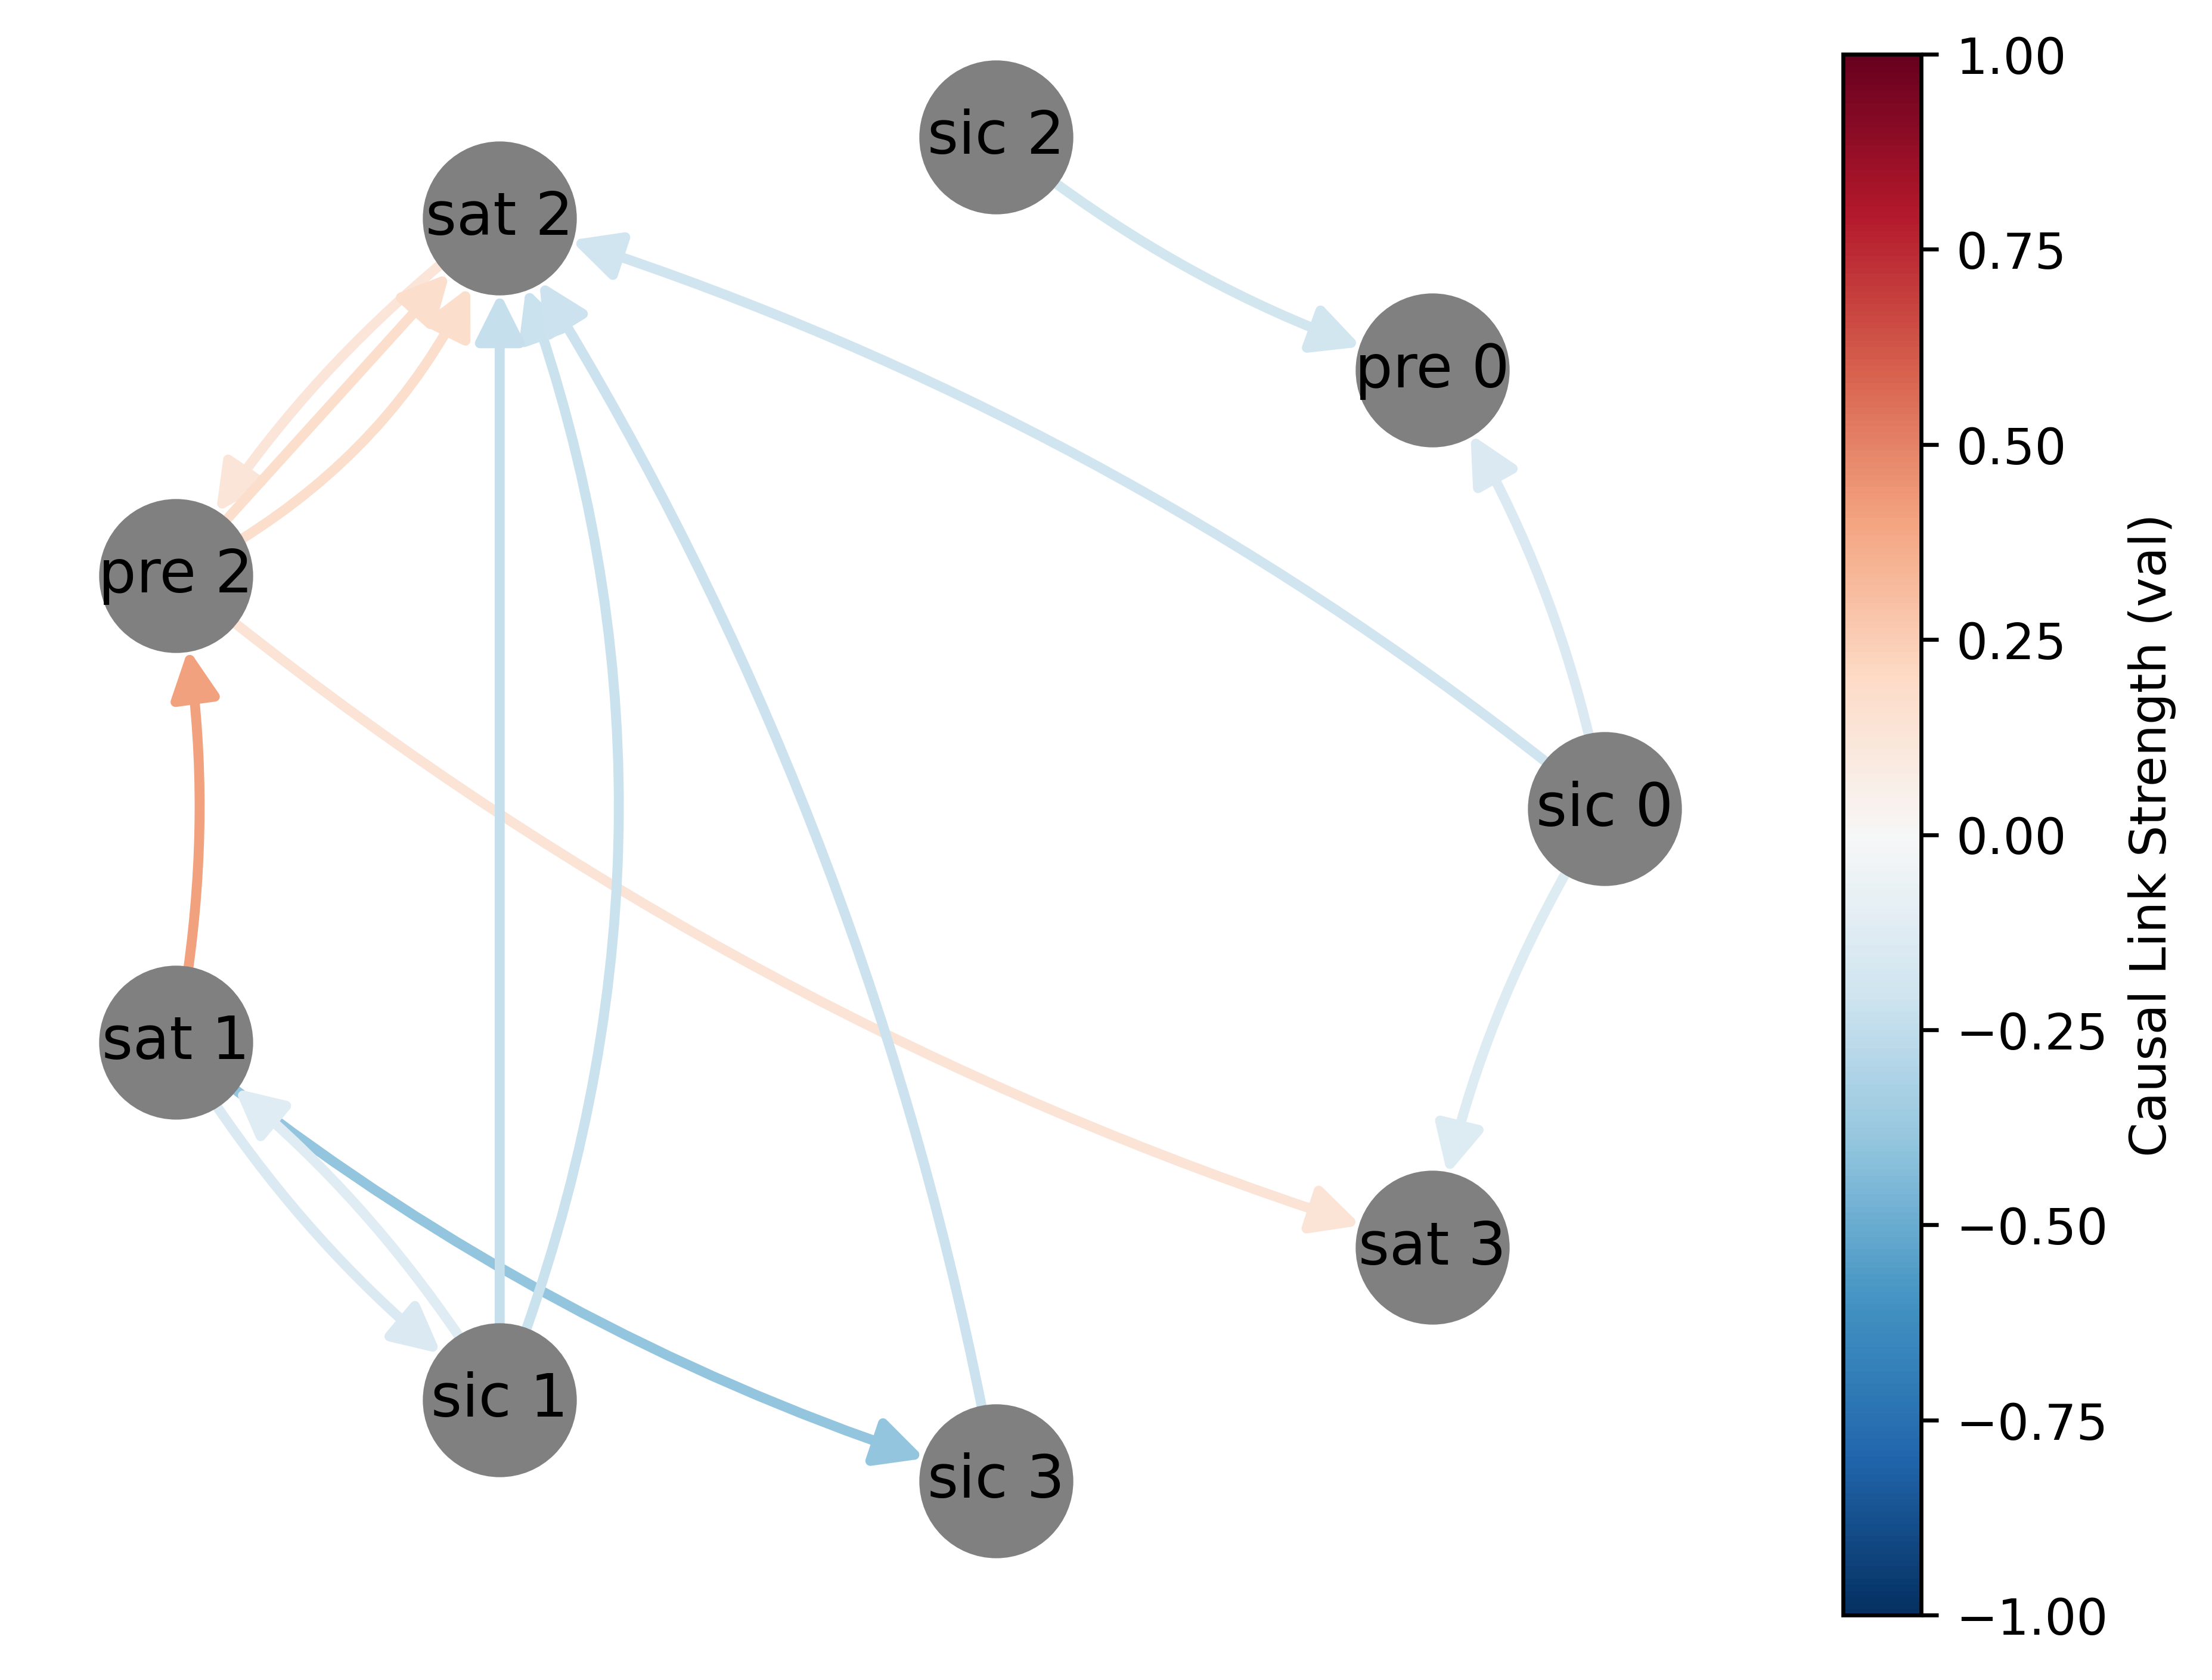

In [175]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_inter_var_causal_links(causal_links):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes and edges based on the causal links
    for target, causes in causal_links.items():
        for cause in causes:
            # Check if the edge already exists, and if so, update the weight attribute
            if G.has_edge(cause['cause'], target):
                G[cause['cause']][target]['weight'].append(cause['val'])
            else:
                G.add_edge(cause['cause'], target, weight=[cause['val']])
    
    # Define the circular layout for the nodes
    pos = nx.circular_layout(G)
    
    # Extract all weights to flatten the list for multiple edges
    weights = []
    for u, v, data in G.edges(data=True):
        weights.extend(data['weight'])
    
    # Prepare edge colors based on their 'val' attribute, using the RdBu_r colormap
    edge_cmap = plt.cm.RdBu_r
    
    # Normalize the color range
    norm = plt.Normalize(-1, 1)

    # Create figure and axis objects
    fig, ax = plt.subplots(dpi=600)
    
    # Draw nodes and edges with specified settings
    nx.draw_networkx_nodes(G, pos, node_color='grey', node_size=900, ax=ax)
    for u, v, data in G.edges(data=True):
        for idx, weight in enumerate(data['weight']):
            # Creating a slight arc for each edge based on its index to separate multiple edges
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], ax=ax,
                                   connectionstyle=f'arc3,rad={0.1*len(data["weight"])-0.2*idx}',
                                   edge_color=edge_cmap(norm(weight)), width=2, 
                                   arrowstyle='-|>', arrowsize=20, node_size=900)
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', ax=ax)
    
    # Add a colorbar with the correct axis
    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, label='Causal Link Strength (val)')
    
    # Title and axis settings
    # plt.title('Inter-Variable Causal Links')
    ax.axis('off')  # Turn off the axis
    plt.tight_layout()
    plt.show()

# Usage with the same causal_links as provided previously
plot_inter_var_causal_links(causal_links)


# Load class labels

In [48]:
# read ds_pre_GMM, ds_sat_GMM, ds_sic_GMM from data/, all are .nc files
import xarray as xr

ds_pre_GMM = xr.open_dataset('data/ds_pre_GMM.nc')
ds_sat_GMM = xr.open_dataset('data/ds_sat_GMM.nc')
ds_sic_GMM = xr.open_dataset('data/ds_sic_GMM.nc')

In [49]:
ds_pre_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

In [50]:
ds_sat_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    TREFHT_centered        (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    TREFHT_c_w             (age, lat, lon) float64 ...
    sat_centered           (age, lat, lon) float32 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

In [52]:
ds_sic_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

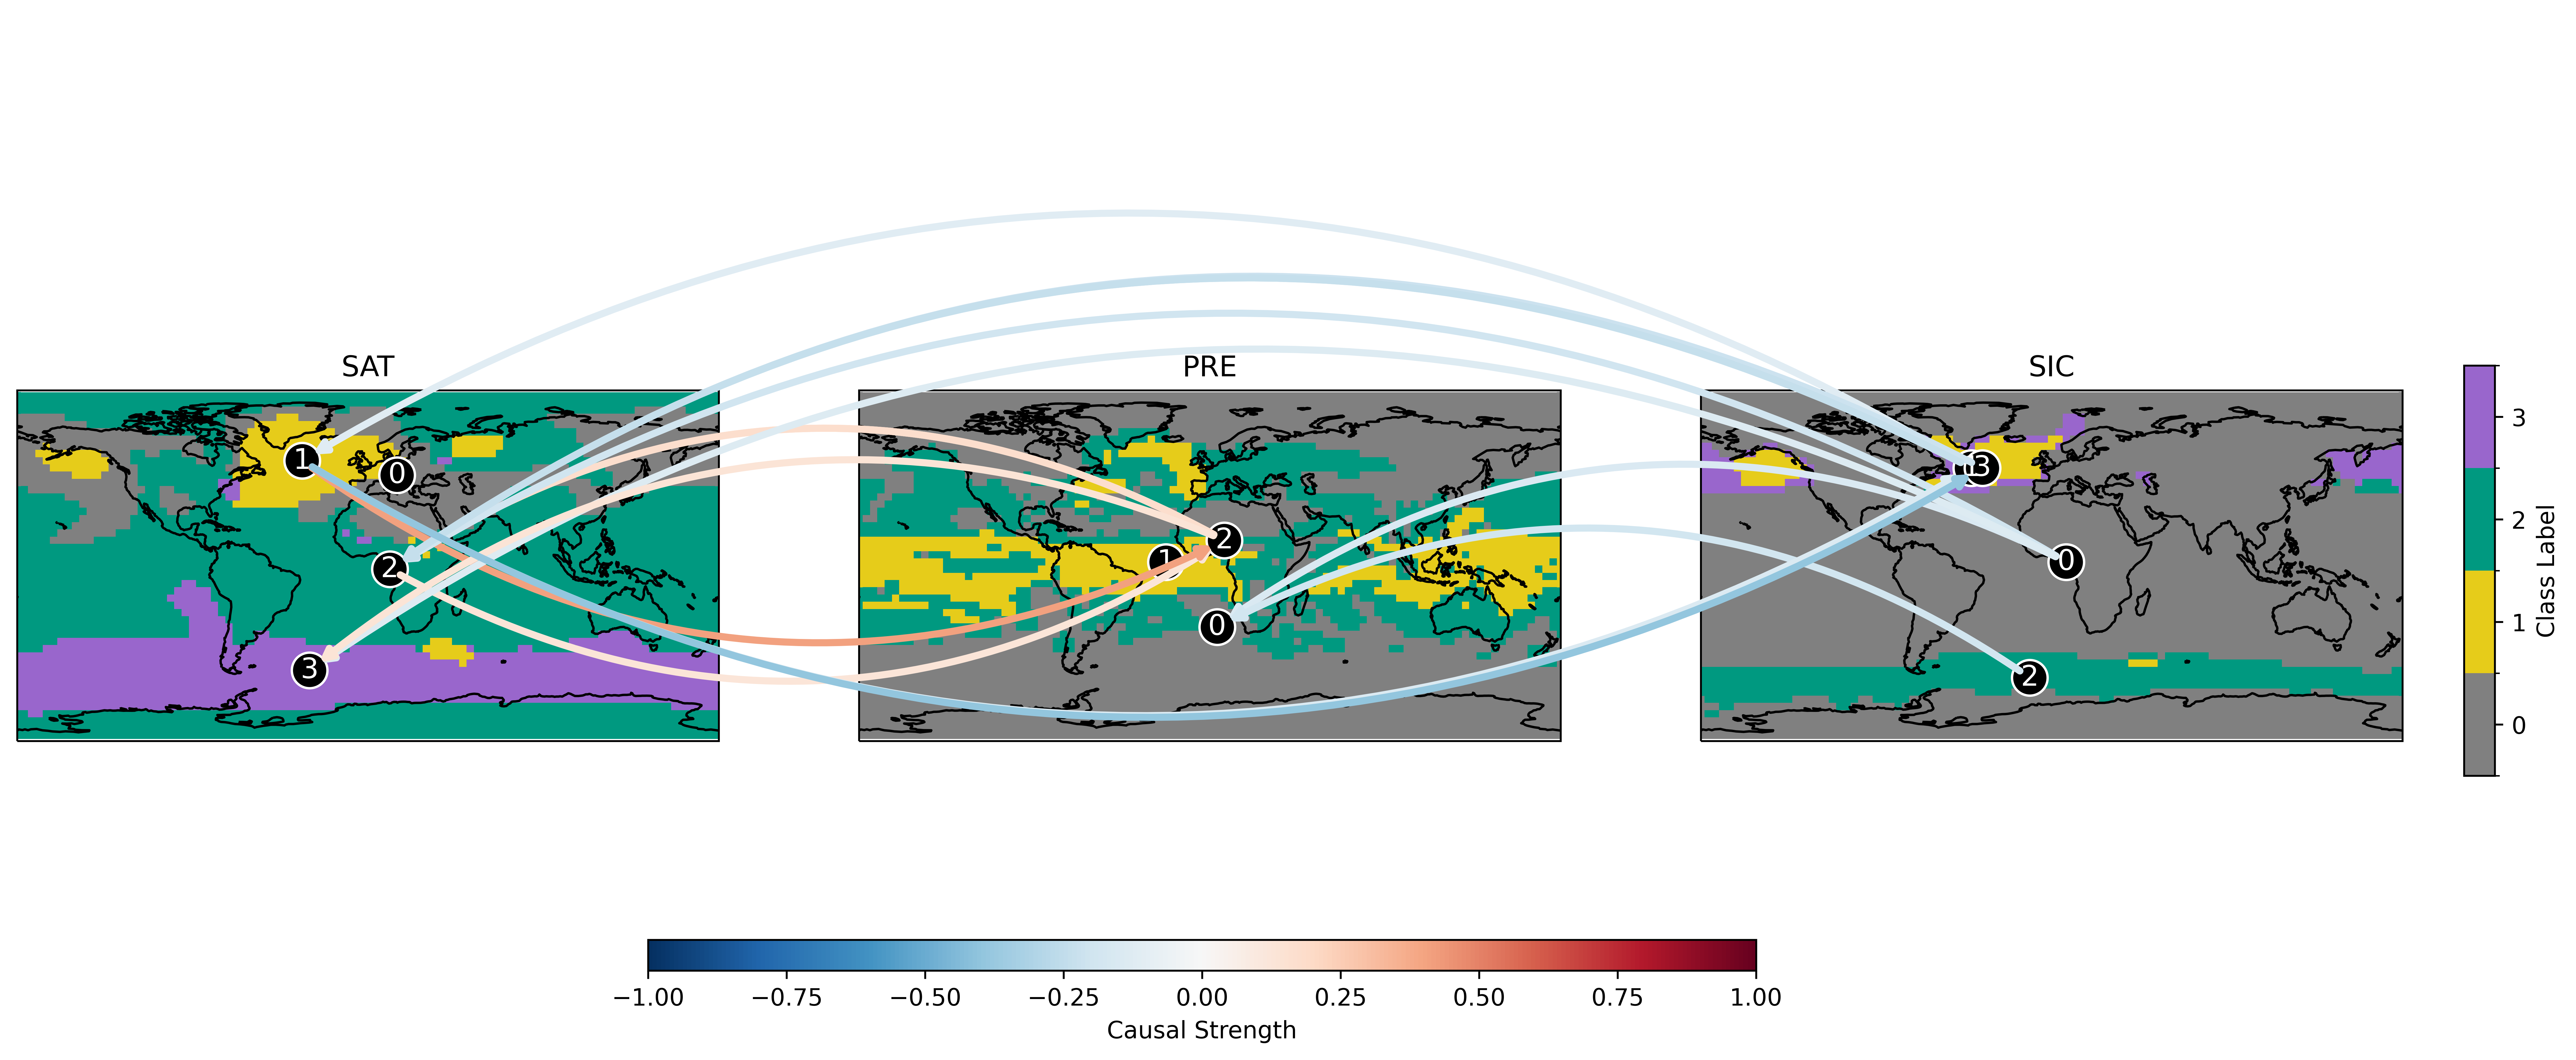

In [176]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import matplotlib.cm as cm
from matplotlib.patches import ConnectionPatch


def plot_vars_class_labels(datasets, causal_links, dpi=100):
    """
    Plots global maps of class labels for provided xarray datasets, with a single, independent color bar.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Calculate the maximum number of unique classes across all datasets
    max_classes = int(max(ds['class_label'].max() for ds in datasets.values()) + 1)

    # Define custom colors limited to the number of unique classes
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
        (0.7, 0.85, 0.9),  # pale cyan
        (0.65, 0.2, 0.2),  # burgundy, avoid if too close to red
        (0.8, 0.7, 0.15),  # mustard
    ][:max_classes]  # limit the colors to the max number of classes
    cmap = ListedColormap(custom_colors)
    norm = BoundaryNorm(boundaries=np.arange(-0.5, max_classes + 0.5, 1), ncolors=max_classes)

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), dpi=dpi, subplot_kw={'projection': ccrs.PlateCarree()})

    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]

    centroids = {}
    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        unique_labels = np.unique(class_label.values)

        lon_adjusted = (ds['lon'].values + 180) % 360 - 180
        lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)
        
        # # Plot the data using pcolormesh, suitable for lat/lon grids
        # pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
        # # Add coastlines for better geographical context
        ax.coastlines()
        
        # Plot the labels
        # im = class_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False, alpha=1)
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        ax.set_global()
        # ax.set_title(title_text)
        ax.set_title(f'{key.upper()}')

        # Compute centroids and plot them
        
        # for i, label in enumerate(unique_labels):
        #     # print(i)
        #     mask = class_label.values == label
        #     lon_mean = np.median(lon[mask])
        #     lat_mean = np.median(lat[mask])
        #     centroids[f'{key} {i}'] = (lon_mean, lat_mean)
            
        #     ax.plot(lon_mean, lat_mean, 'ko', markersize=15, markeredgecolor='white')
        #     # Add label near each centroid
        #     ax.text(lon_mean, lat_mean, f'{label}', color='white', ha='center', va='center', fontsize=12)


        for label in unique_labels:
            mask = class_label == label
            lon_mean = np.median(lon[mask])
            lat_mean = np.median(lat[mask])
            centroids[f'{key} {label}'] = (lon_mean, lat_mean, ax)
            ax.plot(lon_mean, lat_mean, 'ko', markersize=15, markeredgecolor='white')
            # Add label near each centroid
            ax.text(lon_mean, lat_mean, f'{label}', color='white', ha='center', va='center', fontsize=12)

    val_norm = Normalize(vmin=-1, vmax=1)
    cmap_arrow = cm.RdBu_r
    for target, links in causal_links.items():
        target_ax = centroids[target][2]
        target_pos = centroids[target][:2]
        for link in links:
            cause_key = f"{link['cause']}"
            if cause_key in centroids:
                cause_pos = centroids[cause_key][:2]
                cause_ax = centroids[cause_key][2]
                # Creating a new arrow with higher zorder and clip_on set to False
                arrow = ConnectionPatch(xyA=cause_pos, xyB=target_pos, coordsA='data', coordsB='data',
                                        axesA=cause_ax, axesB=target_ax,
                                        arrowstyle="-|>", color=cmap_arrow(val_norm(link['val'])), lw=3, shrinkA=5, shrinkB=5,
                                        connectionstyle="arc3,rad=0.3", zorder=100, clip_on=False)  # High zorder and clipping off
                # Adding the arrow directly to the figure to bypass subplot clipping
                fig.add_artist(arrow)

    # Create an axis for the colorbar on the right side of the figure
    cbar_ax = fig.add_axes([0.92, 0.29, 0.01, 0.4])  # Adjust the position [left, bottom, width, height] as necessary
    cbar = plt.colorbar(pcm, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Class Label')
    cbar.set_ticks(np.arange(0, max_classes))
    cbar.set_ticklabels(np.arange(0, max_classes))

    # Add a color bar for the arrows
    sm = cm.ScalarMappable(cmap=cmap_arrow, norm=val_norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.33, 0.1, 0.36, 0.03])  # Position for bottom colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Causal Strength')

    
    # place holder to make the figure higher
    cbar_T = fig.add_axes([0.33, 1, 0.36, 0.03])  # Position for bottom colorbar
    # turn of ticklabels and set spine in visiable
    cbar_T.axis('off')
    cbar_T.spines['top'].set_visible(True)
    cbar_T.spines['right'].set_visible(True)
    cbar_T.spines['bottom'].set_visible(True)
    cbar_T.spines['left'].set_visible(True)



    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make room for the colorbar

    plt.show()
 

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}
 
plot_vars_class_labels(datasets, causal_links, dpi=600)


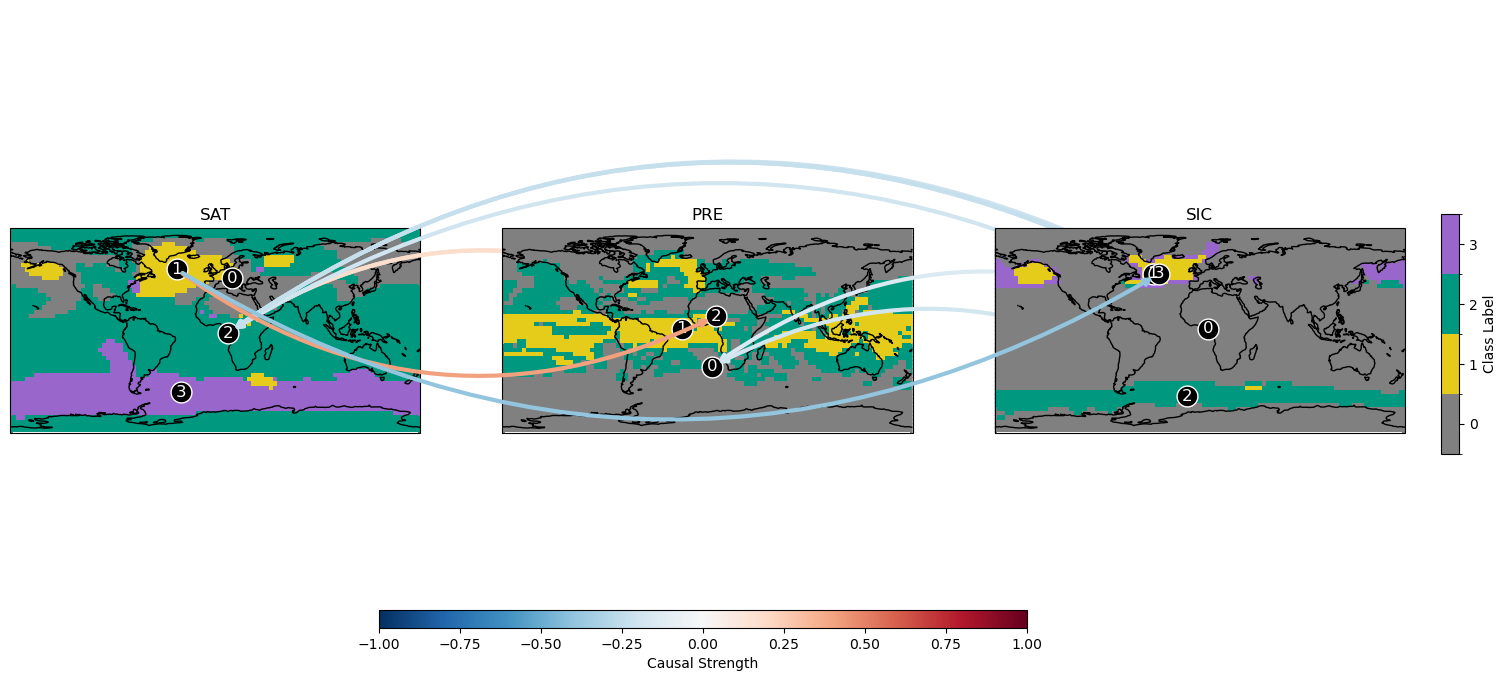

In [147]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import matplotlib.cm as cm
from matplotlib.patches import ConnectionPatch


def plot_vars_class_labels(datasets):
    """
    Plots global maps of class labels for provided xarray datasets, with a single, independent color bar.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Calculate the maximum number of unique classes across all datasets
    max_classes = int(max(ds['class_label'].max() for ds in datasets.values()) + 1)

    # Define custom colors limited to the number of unique classes
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
        (0.7, 0.85, 0.9),  # pale cyan
        (0.65, 0.2, 0.2),  # burgundy, avoid if too close to red
        (0.8, 0.7, 0.15),  # mustard
    ][:max_classes]  # limit the colors to the max number of classes
    cmap = ListedColormap(custom_colors)
    norm = BoundaryNorm(boundaries=np.arange(-0.5, max_classes + 0.5, 1), ncolors=max_classes)

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]

    centroids = {}
    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        unique_labels = np.unique(class_label.values)

        lon_adjusted = (ds['lon'].values + 180) % 360 - 180
        lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)
        
        # # Plot the data using pcolormesh, suitable for lat/lon grids
        # pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
        # # Add coastlines for better geographical context
        ax.coastlines()
        
        # Plot the labels
        # im = class_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False, alpha=1)
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        ax.set_global()
        # ax.set_title(title_text)
        ax.set_title(f'{key.upper()}')

        # Compute centroids and plot them
        
        # for i, label in enumerate(unique_labels):
        #     # print(i)
        #     mask = class_label.values == label
        #     lon_mean = np.median(lon[mask])
        #     lat_mean = np.median(lat[mask])
        #     centroids[f'{key} {i}'] = (lon_mean, lat_mean)
            
        #     ax.plot(lon_mean, lat_mean, 'ko', markersize=15, markeredgecolor='white')
        #     # Add label near each centroid
        #     ax.text(lon_mean, lat_mean, f'{label}', color='white', ha='center', va='center', fontsize=12)


        for label in unique_labels:
            mask = class_label == label
            lon_mean = np.median(lon[mask])
            lat_mean = np.median(lat[mask])
            centroids[f'{key} {label}'] = (lon_mean, lat_mean, ax)
            ax.plot(lon_mean, lat_mean, 'ko', markersize=15, markeredgecolor='white')
            # Add label near each centroid
            ax.text(lon_mean, lat_mean, f'{label}', color='white', ha='center', va='center', fontsize=12)
    
    # print(centroids)

    # # Plot causal links with curved arrows
    # val_norm = Normalize(vmin=-1, vmax=1)  # Adjusted for arrow color range
    # cmap_arrow = cm.RdBu_r
    # for target, links in causal_links.items():
    #     # pring(target)
    #     for link in links:
    #         cause = link['cause']
    #         val = link['val']
    #         # print(cause, target, val)
    #         if cause in centroids and target in centroids:
    #             arrow = ConnectionPatch(xyA=centroids[cause], xyB=centroids[target], coordsA='data', coordsB='data',
    #                                     arrowstyle="-|>", color=cmap_arrow(val_norm(val)), lw=3, shrinkA=8, shrinkB=8, 
    #                                     connectionstyle="arc3,rad=0.3")
    #             ax.add_patch(arrow)

    val_norm = Normalize(vmin=-1, vmax=1)
    cmap_arrow = cm.RdBu_r
    for target, links in causal_links.items():
        target_ax = centroids[target][2]
        target_pos = centroids[target][:2]
        # print('target:', target)    
        for link in links:
            cause_key = f"{link['cause']}"
            # print('cause_key:',cause_key)
            if cause_key in centroids:
                cause_pos = centroids[cause_key][:2]
                cause_ax = centroids[cause_key][2]
                arrow = ConnectionPatch(xyA=cause_pos, xyB=target_pos, coordsA='data', coordsB='data',
                                        axesA=cause_ax, axesB=target_ax,
                                        arrowstyle="-|>", color=cmap_arrow(val_norm(link['val'])), lw=3, shrinkA=5, shrinkB=5,connectionstyle="arc3,rad=0.3",
                                        transform=ccrs.PlateCarree(), zorder=10)
                # arrow.set_clip_on(False)

                target_ax.add_patch(arrow)


    # Create an axis for the colorbar on the right side of the figure
    cbar_ax = fig.add_axes([0.92, 0.29, 0.01, 0.4])  # Adjust the position [left, bottom, width, height] as necessary
    cbar = plt.colorbar(pcm, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Class Label')
    cbar.set_ticks(np.arange(0, max_classes))
    cbar.set_ticklabels(np.arange(0, max_classes))

    # Add a color bar for the arrows
    sm = cm.ScalarMappable(cmap=cmap_arrow, norm=val_norm)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.33, 0, 0.36, 0.03])  # Position for bottom colorbar
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Causal Strength')

    
    # place holder to make the figure higher
    cbar_T = fig.add_axes([0.33, 1, 0.36, 0.03])  # Position for bottom colorbar
    # turn of ticklabels and set spine in visiable
    cbar_T.axis('off')
    cbar_T.spines['top'].set_visible(True)
    cbar_T.spines['right'].set_visible(True)
    cbar_T.spines['bottom'].set_visible(True)
    cbar_T.spines['left'].set_visible(True)



    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make room for the colorbar

    plt.show()
 

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}
 
plot_vars_class_labels(datasets)


0
1
2
3
0
1
2
0
1
2
3
{'sat 0': (15.0, 46.38855811160543), 'sat 1': (-33.75, 53.810274031941425), 'sat 2': (11.25, -1.8555714859932573), 'sat 3': (-30.0, -53.810274031941425), 'pre 0': (3.75, -31.544523284021665), 'pre 1': (-22.5, 1.8555714859932573), 'pre 2': (7.5, 12.988988582088144), 'sic 0': (7.5, 1.8555714859932573), 'sic 1': (-41.25, 50.09945341298685), 'sic 2': (-11.25, -57.520993797969965), 'sic 3': (-35.625, 50.09945341298685)}
sic 3 pre 0 -0.075
sat 2 pre 0 0.098
sat 1 pre 0 0.101
sic 0 pre 0 -0.15
sic 2 pre 0 -0.189
sic 0 pre 1 -0.078
sic 1 pre 1 -0.082
sat 1 pre 1 0.093
sat 3 pre 1 0.115
sat 3 pre 2 0.077
sat 1 pre 2 0.078
sic 2 pre 2 -0.084
sat 0 pre 2 0.085
sic 1 pre 2 -0.102
sat 2 pre 2 0.128
sat 1 pre 2 0.407
sic 1 sat 0 -0.074
sic 1 sat 0 -0.077
pre 1 sat 0 0.08
pre 2 sat 0 0.081
sic 3 sat 1 0.076
sic 1 sat 1 -0.084
sic 1 sat 1 -0.12
sic 3 sat 2 -0.091
sic 2 sat 2 -0.095
pre 0 sat 2 0.096
sic 2 sat 2 -0.097
pre 2 sat 2 0.174
pre 2 sat 2 0.175
sic 0 sat 2 -0.203
sic 3 s

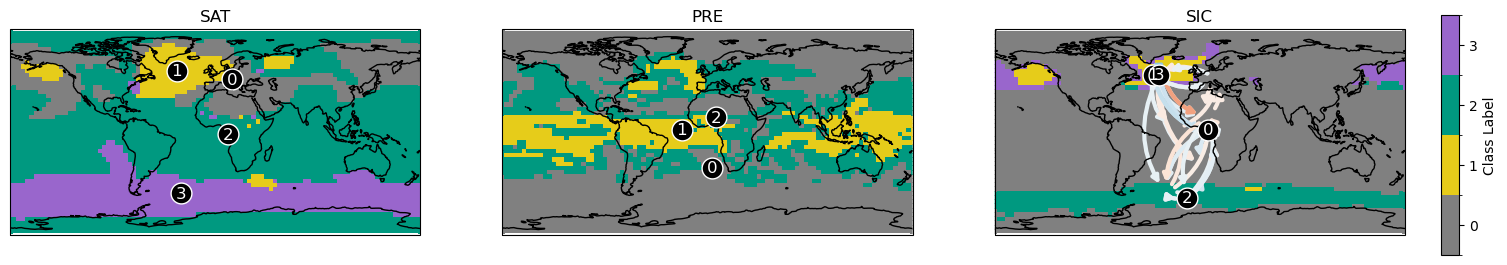

In [94]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
import matplotlib.cm as cm
from matplotlib.patches import ConnectionPatch


def plot_vars_class_labels(datasets):
    """
    Plots global maps of class labels for provided xarray datasets, with a single, independent color bar.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Calculate the maximum number of unique classes across all datasets
    max_classes = int(max(ds['class_label'].max() for ds in datasets.values()) + 1)

    # Define custom colors limited to the number of unique classes
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
        (0.7, 0.85, 0.9),  # pale cyan
        (0.65, 0.2, 0.2),  # burgundy, avoid if too close to red
        (0.8, 0.7, 0.15),  # mustard
    ][:max_classes]  # limit the colors to the max number of classes
    cmap = ListedColormap(custom_colors)
    norm = BoundaryNorm(boundaries=np.arange(-0.5, max_classes + 0.5, 1), ncolors=max_classes)

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]

    centroids = {}
    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        unique_labels = np.unique(class_label.values)

        lon_adjusted = (ds['lon'].values + 180) % 360 - 180
        lon, lat = np.meshgrid(lon_adjusted, ds['lat'].values)
        
        # # Plot the data using pcolormesh, suitable for lat/lon grids
        # pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
        # # Add coastlines for better geographical context
        ax.coastlines()
        
        # Plot the labels
        # im = class_label.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto', add_colorbar=False, alpha=1)
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        ax.set_global()
        # ax.set_title(title_text)
        ax.set_title(f'{key.upper()}')

        # Compute centroids and plot them
        
        for i, label in enumerate(unique_labels):
            print(i)
            mask = class_label.values == label
            lon_mean = np.median(lon[mask])
            lat_mean = np.median(lat[mask])
            centroids[f'{key} {i}'] = (lon_mean, lat_mean)
            
            ax.plot(lon_mean, lat_mean, 'ko', markersize=15, markeredgecolor='white')
            # Add label near each centroid
            ax.text(lon_mean, lat_mean, f'{label}', color='white', ha='center', va='center', fontsize=12)
    
    print(centroids)

    # Plot causal links with curved arrows
    val_norm = Normalize(vmin=-1, vmax=1)  # Adjusted for arrow color range
    cmap_arrow = cm.RdBu_r
    for target, links in causal_links.items():
        # pring(target)
        for link in links:
            cause = link['cause']
            val = link['val']
            print(cause, target, val)
            if cause in centroids and target in centroids:
                arrow = ConnectionPatch(xyA=centroids[cause], xyB=centroids[target], coordsA='data', coordsB='data',
                                        arrowstyle="-|>", color=cmap_arrow(val_norm(val)), lw=3, shrinkA=8, shrinkB=8, 
                                        connectionstyle="arc3,rad=0.3")
                ax.add_patch(arrow)


    # Create an axis for the colorbar on the right side of the figure
    cbar_ax = fig.add_axes([0.92, 0.29, 0.01, 0.4])  # Adjust the position [left, bottom, width, height] as necessary
    cbar = plt.colorbar(pcm, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Class Label')
    cbar.set_ticks(np.arange(0, max_classes))
    cbar.set_ticklabels(np.arange(0, max_classes))

    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make room for the colorbar

    plt.show()
 

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}

plot_vars_class_labels(datasets)


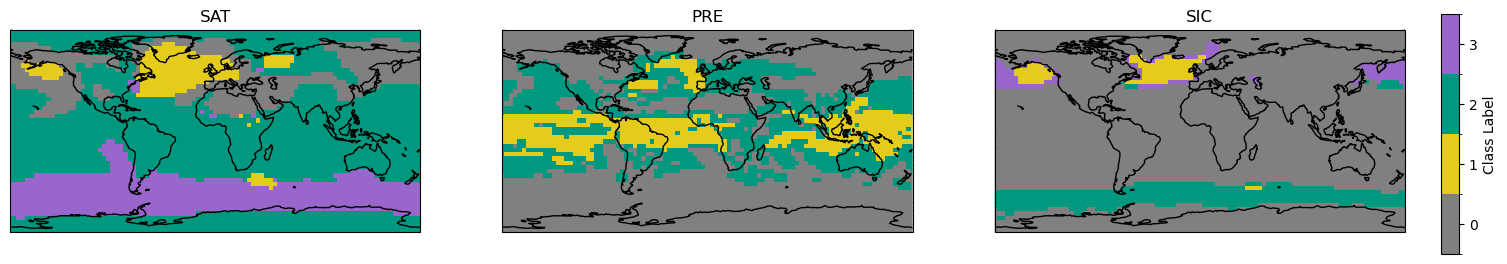

In [67]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_vars_class_labels(datasets):
    """
    Plots global maps of class labels for provided xarray datasets, with a single, independent color bar.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Calculate the maximum number of unique classes across all datasets
    max_classes = int(max(ds['class_label'].max() for ds in datasets.values()) + 1)

    # Define custom colors limited to the number of unique classes
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
    ][:max_classes]  # limit the colors to the max number of classes
    cmap = ListedColormap(custom_colors)
    norm = BoundaryNorm(boundaries=np.arange(-0.5, max_classes + 0.5, 1), ncolors=max_classes)

    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]

    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        
        # Plot the data using pcolormesh, suitable for lat/lon grids
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
        
        # Add coastlines for better geographical context
        ax.coastlines()
        ax.set_title(f'{key.upper()}')

    # Create an axis for the colorbar on the right side of the figure
    cbar_ax = fig.add_axes([0.92, 0.29, 0.01, 0.4])  # Adjust the position [left, bottom, width, height] as necessary
    cbar = plt.colorbar(pcm, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Class Label')
    cbar.set_ticks(np.arange(0, max_classes))
    cbar.set_ticklabels(np.arange(0, max_classes))

    # plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rect parameter to make room for the colorbar

    plt.show()

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}

plot_vars_class_labels(datasets)


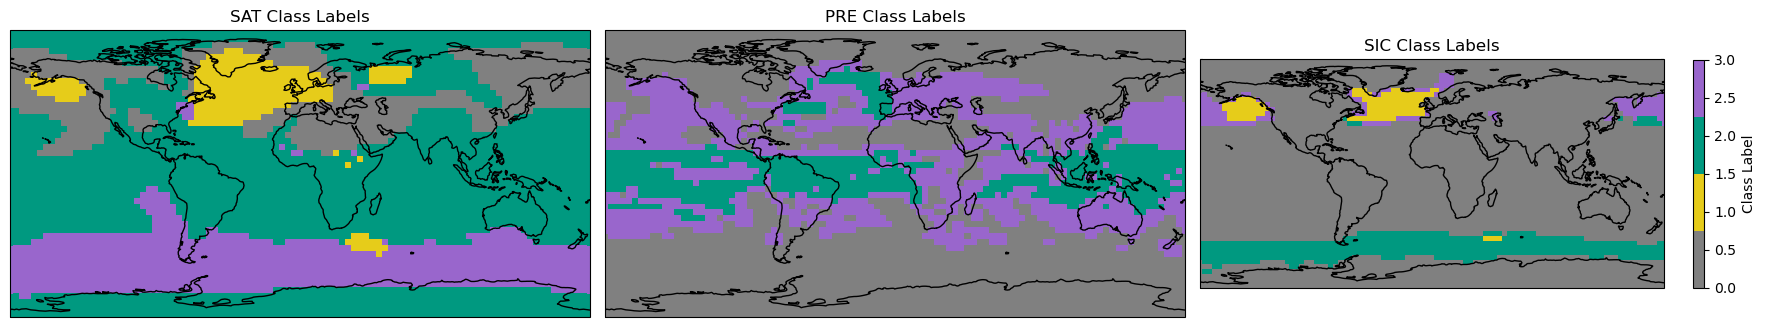

In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import ListedColormap

def plot_vars_class_labels(datasets):
    """
    Plots global maps of class labels for provided xarray datasets, showing a single color bar for the last subplot.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Calculate the maximum number of unique classes across all datasets
    max_classes = max(ds['class_label'].max() for ds in datasets.values()) + 1

    # Create a custom colormap with only as many colors as the maximum number of classes
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
    ][:int(max_classes)]  # limit the colors to the max number of classes
    cmap = ListedColormap(custom_colors)

    # Create a figure with subplots in a row, one for each dataset
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]
    
    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        
        # Plot the data using pcolormesh, suitable for lat/lon grids
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, transform=ccrs.PlateCarree())
        
        # Add coastlines for better geographical context
        ax.coastlines()
        ax.set_title(f'{key.upper()} Class Labels')

    # Add a single color bar to the last subplot
    cbar = plt.colorbar(pcm, ax=axs[-1], orientation='vertical', pad=0.05, shrink=0.4)
    cbar.set_label('Class Label')

    plt.tight_layout()
    plt.show()

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}

plot_vars_class_labels(datasets)


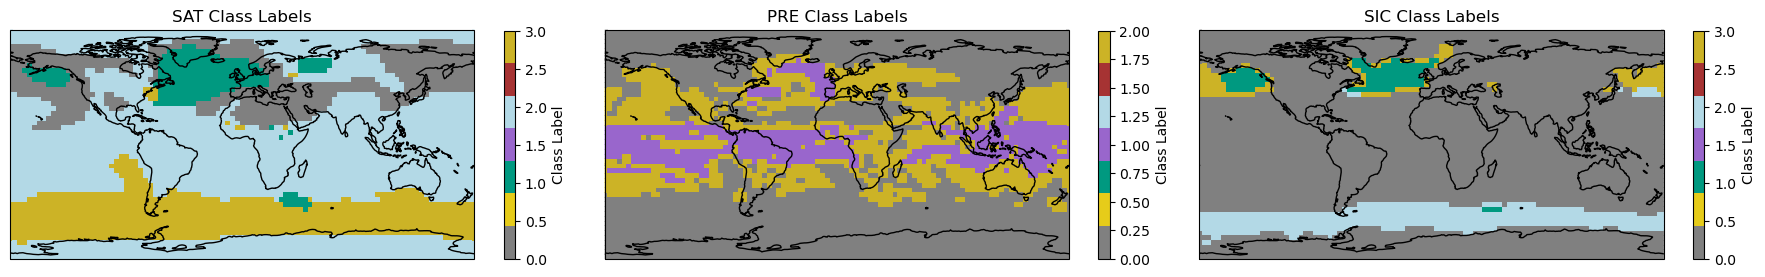

In [57]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from matplotlib.colors import ListedColormap

def plot_vars_class_labels(datasets):
    """
    Plots global maps of class labels for provided xarray datasets.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Create a figure with subplots in a row, one for each dataset
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]
    
    # Define a custom colormap that stands out against RdBu_r
    custom_colors = [
        (0.5, 0.5, 0.5),  # grey
        (0.9, 0.8, 0.1),  # yellow
        (0.0, 0.6, 0.5),  # teal
        (0.6, 0.4, 0.8),  # purple
        (0.7, 0.85, 0.9),  # pale cyan
        (0.65, 0.2, 0.2),  # burgundy, avoid if too close to red
        (0.8, 0.7, 0.15),  # mustard
    ]
    cmap = ListedColormap(custom_colors)

    # Iterate over the datasets and their axes to plot each
    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        
        # Plot the data using pcolormesh, suitable for lat/lon grids
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap=cmap, transform=ccrs.PlateCarree())
        
        # Add coastlines for better geographical context
        ax.coastlines()
        ax.set_title(f'{key.upper()} Class Labels')
        
        # Setup the color bar
        cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.05, shrink=0.4)
        cbar.set_label('Class Label')

    plt.tight_layout()
    plt.show()

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}

plot_vars_class_labels(datasets)


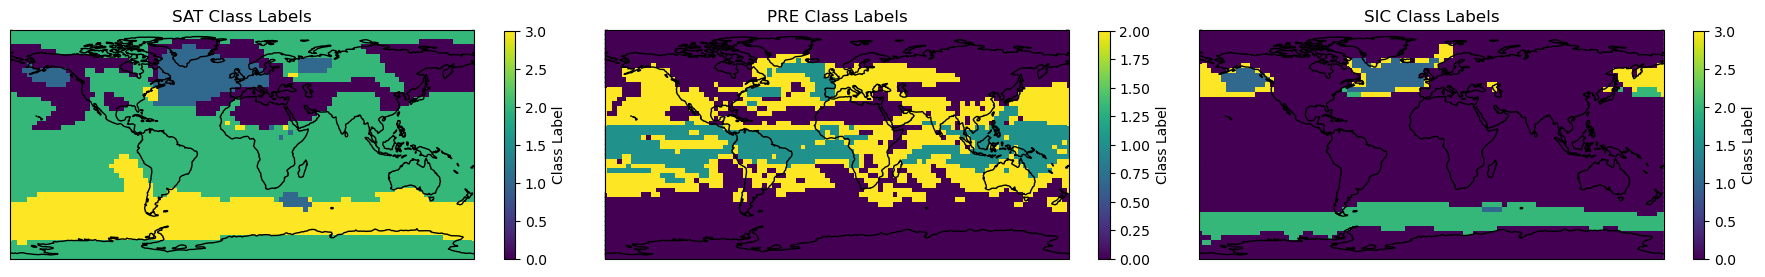

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

def plot_vars_class_labels(datasets):
    """
    Plots global maps of class labels for provided xarray datasets.
    
    Parameters:
    datasets : dict
        Dictionary of xarray datasets with keys indicating the dataset names ('sat', 'pre', 'sic').
    """
    # Create a figure with subplots in a row, one for each dataset
    fig, axs = plt.subplots(nrows=1, ncols=len(datasets), figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    if len(datasets) == 1:  # If there's only one dataset, axs will not be an array
        axs = [axs]
    
    # Iterate over the datasets and their axes to plot each
    for ax, (key, ds) in zip(axs, datasets.items()):
        # Select the 'class_label' data for plotting
        class_label = ds['class_label']
        
        # Plot the data using pcolormesh, which is suitable for lat/lon grids
        pcm = ax.pcolormesh(ds['lon'], ds['lat'], class_label, cmap='viridis', transform=ccrs.PlateCarree())
        
        # Add coastlines for better geographical context
        ax.coastlines()
        ax.set_title(f'{key.upper()} Class Labels')
        
        # Add a colorbar for each subplot
        fig.colorbar(pcm, ax=ax, orientation='vertical', label='Class Label', shrink=0.4)
    
    plt.tight_layout()
    plt.show()

# Example usage:
datasets = {
    'sat': ds_sat_GMM,
    'pre': ds_pre_GMM,
    'sic': ds_sic_GMM
}

plot_vars_class_labels(datasets)
